In [29]:
from scipy.stats import mannwhitneyu, ttest_ind,f_oneway
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
import matplotlib.pyplot as plt

sns.set(style='white',
    palette='deep',
    font='sans-serif',
    font_scale=1.3,)

%config Completer.use_jedi = False


In [30]:
color = sns.color_palette("hls", 8)
sc = [color[1], color[3], color[-1], color[-2]]

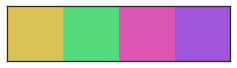

In [31]:
sns.palplot(sc)

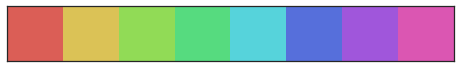

In [32]:
sns.palplot(color)

In [33]:
df = pd.read_excel('./kmer-raw-mean.xlsx',sheet_name = 'Sheet1')
s1 = df.groupby('k-mer')['normol_mean'].mean()
s2 = df.groupby('k-mer')['cancer_mean'].mean()
fill_4 = (s1/100)['4-mer']
fill_5 = 1e-6#(s1/100)['5-mer']-3e-6
df2 = df[df['k-mer'] == '2-mer']
df3 = df[df['k-mer'] == '3-mer']
df4 = df[df['k-mer'] == '4-mer'].fillna(fill_5)
df5 = df[df['k-mer'] == '5-mer'].fillna(fill_5)

In [34]:
df.groupby('k-mer')['normol_mean'].min()/100

k-mer
2-mer    0.003681
3-mer    0.000003
4-mer    0.000008
5-mer         NaN
Name: normol_mean, dtype: float64

In [35]:
fill_4, fill_5

(7.5057369999999995e-06, 1e-06)

In [36]:
df = df2.append(df3).append(df4).append(df5)

In [37]:
kmer = df[['k-mer']]

In [38]:
def from_mean_std_get_samples(desired_mean, desired_std_dev, num_samples):
    #np.random.seed(123)
    samples = np.random.normal(loc=0.0, scale=desired_std_dev, size=num_samples)
    actual_mean = np.mean(samples)
    actual_std = np.std(samples)

    zero_mean_samples = samples - (actual_mean)
    zero_mean_mean = np.mean(zero_mean_samples)
    zero_mean_std = np.std(zero_mean_samples)

    scaled_samples = zero_mean_samples * (desired_std_dev/zero_mean_std)
    scaled_mean = np.mean(scaled_samples)
    scaled_std = np.std(scaled_samples)

    final_samples = scaled_samples + desired_mean
    final_mean = np.mean(final_samples)
    final_std = np.std(final_samples)
    return final_samples

def _get_repeats(ts, repeats=3):

    cm = ts.cancer_mean
    nm = ts.normol_mean
    x = 100
    c = np.random.normal(cm, cm/x, repeats)
    n = np.random.normal(nm, nm/x, repeats) 
    
    c1 = from_mean_std_get_samples(cm, c.std(), repeats)
    n1 = from_mean_std_get_samples(nm, n.std(), repeats)
    
    #print(c1.mean())
    #n = nm_n+nm  
    return np.concatenate((c1, n1))


def get_p(ts, repeats=3):
    c = ts.tolist()[:repeats]
    n = ts.tolist()[repeats:]
    manuwhite_p = mannwhitneyu(c, n, use_continuity=False, alternative='two-sided').pvalue
    
    ttest_p = ttest_ind(c, n).pvalue
    
    oneway_ANOVA_p = f_oneway(c,n).pvalue
    
    return -np.log10(manuwhite_p), -np.log10(ttest_p), -np.log10(oneway_ANOVA_p)

In [39]:
dfn = df.apply(_get_repeats,axis=1).apply(pd.Series)

In [40]:
dfn

,0,1,2,3,4,5
0,103.963776,106.007988,104.717136,3.677933e+01,3.731838e+01,3.703790e+01
1,63.399436,64.396016,64.180319,3.121815e+01,3.038701e+01,3.064647e+01
2,63.000931,63.282312,61.673580,3.455121e+01,3.491492e+01,3.452832e+01
3,62.219951,63.128096,61.864608,4.442736e+01,4.463609e+01,4.463795e+01
4,61.469374,62.382951,62.147572,2.031372e+01,1.992820e+01,2.014137e+01
...,...,...,...,...,...,...
1551,0.000763,0.000780,0.000761,9.979310e-07,1.008226e-06,9.938428e-07
1552,0.000760,0.000759,0.000785,1.003861e-06,1.001123e-06,9.950160e-07
1553,0.000766,0.000765,0.000773,1.002872e-06,1.007136e-06,9.899913e-07
1554,0.000763,0.000766,0.000774,1.002924e-06,9.918436e-07,1.005232e-06


In [41]:
dfres = dfn.apply(get_p,axis=1).apply(pd.Series)
dfres.columns = ['manuwhite_p', 'ttest_p', 'oneway_ANOVA_p']


l1 = dfn[[0,1,2]].mean(axis=1)
l2 = dfn[[3,4,5]].mean(axis=1)
fc = np.log2(l1/l2).to_frame(name = 'log2_fold_change')
fc= fc.join(np.log10(l1/l2).to_frame(name = 'log10_fold_change'))

dfp = fc.join(dfres)
dfp = dfp.join(kmer)

In [42]:
dfp

,log2_fold_change,log10_fold_change,manuwhite_p,ttest_p,oneway_ANOVA_p,k-mer
0,1.501605,0.452028,1.305091,7.387637,7.387637,2-mer
1,1.057278,0.318272,1.305091,6.945786,6.945786,2-mer
2,0.853895,0.257048,1.305091,6.174929,6.174929,2-mer
3,0.485663,0.146199,1.305091,5.897354,5.897354,2-mer
4,1.623081,0.488596,1.305091,7.826369,7.826369,2-mer
...,...,...,...,...,...,...
1551,9.584756,2.885299,1.305091,7.628285,7.628285,5-mer
1552,9.584756,2.885299,1.305091,6.981692,6.981692,5-mer
1553,9.584756,2.885299,1.305091,9.237430,9.237430,5-mer
1554,9.584756,2.885299,1.305091,8.668001,8.668001,5-mer


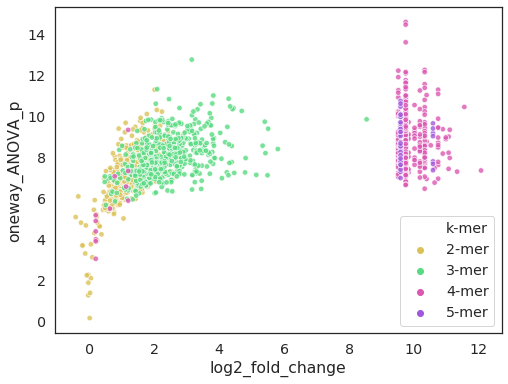

In [43]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x = 'log2_fold_change', y = 'oneway_ANOVA_p', 
                edgecolor = 'w', s = 30,
                data = dfp, hue = 'k-mer', ax = ax, 
                palette = sc, alpha = 0.8)

#ax.set_xlim(-1,3.5)
#ax.set_ylim(-0.5,9)

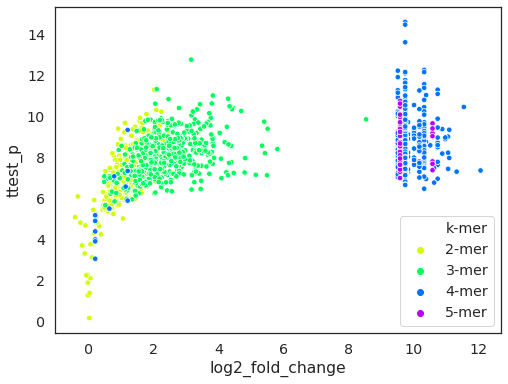

In [44]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(x = 'log2_fold_change', y = 'ttest_p', 
                edgecolor = 'w', s = 30,
                data = dfp, hue = 'k-mer', ax = ax, 
                palette = 'hsv', alpha = 1)

#ax.set_ylim(-0.5,8)

In [45]:
dfp

,log2_fold_change,log10_fold_change,manuwhite_p,ttest_p,oneway_ANOVA_p,k-mer
0,1.501605,0.452028,1.305091,7.387637,7.387637,2-mer
1,1.057278,0.318272,1.305091,6.945786,6.945786,2-mer
2,0.853895,0.257048,1.305091,6.174929,6.174929,2-mer
3,0.485663,0.146199,1.305091,5.897354,5.897354,2-mer
4,1.623081,0.488596,1.305091,7.826369,7.826369,2-mer
...,...,...,...,...,...,...
1551,9.584756,2.885299,1.305091,7.628285,7.628285,5-mer
1552,9.584756,2.885299,1.305091,6.981692,6.981692,5-mer
1553,9.584756,2.885299,1.305091,9.237430,9.237430,5-mer
1554,9.584756,2.885299,1.305091,8.668001,8.668001,5-mer


k-mer
2-mer    AxesSubplot(0.125,0.125;0.775x0.755)
3-mer    AxesSubplot(0.125,0.125;0.775x0.755)
4-mer    AxesSubplot(0.125,0.125;0.775x0.755)
5-mer    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

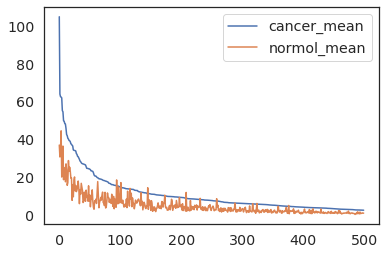

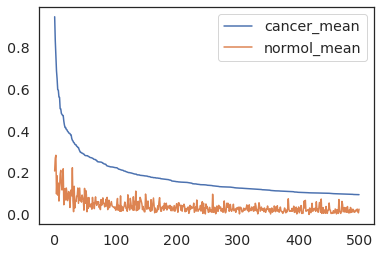

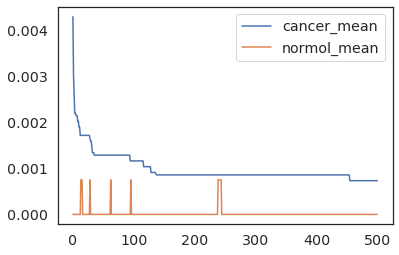

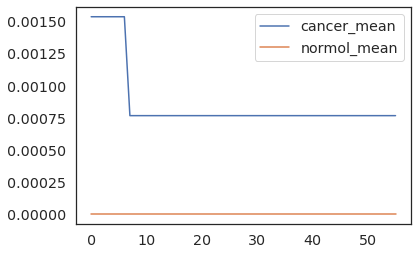

In [46]:
df.groupby('k-mer').apply(lambda x:x.sort_values('cancer_mean', ascending=False).reset_index(drop=True).plot())

In [50]:
dfn.to_excel('kmer-raw.xlsx')

In [51]:
dfp.to_excel('kmer-volcano-xy.xlsx')